<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дорогой студент!

В домашнем задании Ultra Pro занятия по обработке тектсов с помощью НС мы ставим задачу распознать уже не 6, как ранее, а целых 20 русских писателей! Это подразумевает и больший размер базы для обучения соответственно. Ячейка для скачивания базы уже включена в ноутбук задания.


 В задании необходимо выполнить следующие пункты:

  1. Загрузить саму базу по ссылке и подговить файлы базы для обработки.
  2. Создать обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка. При этом для разбивки необходимо применить цикл.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети не менее 95% на проверочной выборке модели Bag of Words и 75-80% - для модели Embedding.
   


## Загрузка данных

In [ ]:
import gdown                                      # Подключим функцию gdown
file_id = '1TeJxgfr2ZEY5Elil7XgM8WW7njI9Toqj'     # Обозначим ID файла в рамках ссылки
file_name = 'writers.zip'                         # Обозначим имя архива с базой
path = 'https://drive.google.com/uc?id='+file_id  # Укажем директорию для скачивания: ссылка на гугл-диск + ID файла
gdown.download(path, file_name, quiet=False)      # Скачивание файла

Downloading...
From: https://drive.google.com/uc?id=1TeJxgfr2ZEY5Elil7XgM8WW7njI9Toqj
To: /content/writers.zip
28.5MB [00:00, 42.7MB/s]


'writers.zip'

In [ ]:
#импорт библиотек
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, SpatialDropout1D
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import gc

In [ ]:
#извлекаем базу
!unzip -q '/content/writers.zip' -d /content/texts

writers/Русские писатели/:  mismatching "local" filename (writers/╨а╤Г╤Б╤Б╨║╨╕╨╡ ╨┐╨╕╤Б╨░╤В╨╡╨╗╨╕/),
         continuing with "central" filename version
writers/Русские писатели/Беляев.txt:  mismatching "local" filename (writers/╨а╤Г╤Б╤Б╨║╨╕╨╡ ╨┐╨╕╤Б╨░╤В╨╡╨╗╨╕/╨С╨╡╨╗╤П╨╡╨▓.txt),
         continuing with "central" filename version
writers/Русские писатели/Булгаков.txt:  mismatching "local" filename (writers/╨а╤Г╤Б╤Б╨║╨╕╨╡ ╨┐╨╕╤Б╨░╤В╨╡╨╗╨╕/╨С╤Г╨╗╨│╨░╨║╨╛╨▓.txt),
         continuing with "central" filename version
writers/Русские писатели/Васильев.txt:  mismatching "local" filename (writers/╨а╤Г╤Б╤Б╨║╨╕╨╡ ╨┐╨╕╤Б╨░╤В╨╡╨╗╨╕/╨Т╨░╤Б╨╕╨╗╤М╨╡╨▓.txt),
         continuing with "central" filename version
writers/Русские писатели/Гоголь.txt:  mismatching "local" filename (writers/╨а╤Г╤Б╤Б╨║╨╕╨╡ ╨┐╨╕╤Б╨░╤В╨╡╨╗╨╕/╨У╨╛╨│╨╛╨╗╤М.txt),
         continuing with "central" filename version
writers/Русские писатели/Гончаров.txt:  mismatching "local" filename (writers/╨а╤Г╤Б╤Б╨║╨╕╨╡ ╨┐╨╕╤Б╨░╤В╨╡╨╗╨╕/╨У╨╛╨╜╤З╨

In [ ]:
#функция для чтения файла
def readText(fileName):
    #открываем файл в режиме чтения
    x = open(fileName, 'r')
    #читаем текст
    txt = x.read()
    #весь текст соберем в одну строку
    txt = txt.replace('\n', ' ')
    #возвращаем текст
    return txt

In [ ]:
#объявляем классы
className = ['Беляев', 'Булгаков', 'Васильев', 'Гоголь', 'Гончаров',
             'Горький', 'Грибоедов', 'Достоевский', 'Каверин', 'Катаев',
             'Куприн', 'Лермонтов', 'Лесков', 'Носов', 'Пастернак',
             'Пушкин', 'Толстой', 'Тургенев', 'Чехов', 'Шолохов']
#считаем кол-во классов
nClasses = len(className)

In [ ]:
#сформируем выборку
texts = []
#пройдем по каждому классу
for i in className:
    #пройдем по каждому файлу в папке с текстами
    for j in os.listdir('/content/texts/writers/Русские писатели/'):
        #проверим, содержит ли файл в названии имя класса
        if i in j:
            #добавляем в выборку и выведем информацию
            texts.append(readText('/content/texts/writers/Русские писатели/' + j))
            print(j, 'добавлен в выборку')

Беляев.txt добавлен в выборку
Булгаков.txt добавлен в выборку
Васильев.txt добавлен в выборку
Гоголь.txt добавлен в выборку
Гончаров.txt добавлен в выборку
Горький.txt добавлен в выборку
Грибоедов.txt добавлен в выборку
Достоевский.txt добавлен в выборку
Каверин.txt добавлен в выборку
Катаев.txt добавлен в выборку
Куприн.txt добавлен в выборку
Лермонтов.txt добавлен в выборку
Лесков.txt добавлен в выборку
Носов.txt добавлен в выборку
Пастернак.txt добавлен в выборку
Пушкин.txt добавлен в выборку
Толстой.txt добавлен в выборку
Тургенев.txt добавлен в выборку
Чехов.txt добавлен в выборку
Шолохов.txt добавлен в выборку


In [ ]:
#посмотрим часть текста и его длину
print(texts[0][:300])
print(len(texts[0]))

Часть первая  I. На палубе   Большой трансатлантический пароход «Вениамин Франклин» стоял в генуэзской гавани, готовый к отплытию. На берегу была обычная суета, слышались крики разноязычной, пестрой толпы, а на пароходе уже наступил момент той напряженной, нервной тишины, которая невольно охватывает
2255253


In [ ]:
#разделим тексты на обучающую и проверочную части
#создадим переменные для обучающей и проверочной выборок
x_train = []
x_test = [] 

#циклом пройдемся по всем текстам писателей
for i in range(len(texts)):
    #поделим тексты на выборки
    text_train, text_test = train_test_split(texts[i].split(), test_size=0.2)
    #добавим в каждую выборку часть
    x_train.append(' '.join(text_train))
    x_test.append(' '.join(text_test))

In [ ]:
#определяем макс.кол-во слов, учитываемое при обучении текстов
maxWordsCount = 10000
#превратим текст в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', oov_token='unknown')
#соберем словарь частотности
tokenizer.fit_on_texts(x_train)
#вытащим индексы слов для просмотра
items = list(tokenizer.word_index.items())
#посмотрим 100 самых часто встречающихся слов и размер словаря
print(items[:100])
print('Размер словаря:', len(items), 'слов')

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('на', 5), ('что', 6), ('с', 7), ('я', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('его', 13), ('к', 14), ('но', 15), ('это', 16), ('по', 17), ('за', 18), ('у', 19), ('она', 20), ('все', 21), ('из', 22), ('так', 23), ('же', 24), ('от', 25), ('было', 26), ('ты', 27), ('вы', 28), ('мне', 29), ('о', 30), ('меня', 31), ('да', 32), ('бы', 33), ('ее', 34), ('только', 35), ('был', 36), ('ему', 37), ('когда', 38), ('еще', 39), ('сказал', 40), ('мы', 41), ('вот', 42), ('они', 43), ('уже', 44), ('ни', 45), ('до', 46), ('их', 47), ('нет', 48), ('для', 49), ('ну', 50), ('него', 51), ('или', 52), ('если', 53), ('теперь', 54), ('ли', 55), ('быть', 56), ('под', 57), ('очень', 58), ('себя', 59), ('вас', 60), ('была', 61), ('даже', 62), ('где', 63), ('во', 64), ('есть', 65), ('вам', 66), ('ничего', 67), ('может', 68), ('чем', 69), ('со', 70), ('тут', 71), ('чтобы', 72), ('были', 73), ('всё', 74), ('потом', 75), ('кто', 76), ('время', 77), ('себе',

In [ ]:
#преобразуем тексты в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(x_train)
testWordIndexes = tokenizer.texts_to_sequences(x_test)

print('Оригинальный текст:', x_train[13][:100])
print('В виде последовательности индексов:', trainWordIndexes[0][:20])

Оригинальный текст: Коржика. деньги-то больницей на лежал Мишка,— лом — он ней звонит: сто, руками. потому очень сказать
В виде последовательности индексов: [5896, 383, 31, 36, 44, 27, 24, 56, 9497, 137, 1756, 3490, 1, 1, 1, 4, 1, 6001, 1, 8333]


In [ ]:
print("Статистика по обучающим текстам:")

#создадим переменные для подсчета символов и слов в обучающих текстах
symbolsTrainText = 0
wordsTrainText = 0

#пройдем по всем классам и посчитаем символы и слова
for i in range(nClasses):
  print(className[i], " "*(12-len(className[i])), len(x_train[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(x_train[i])
  wordsTrainText += len(trainWordIndexes[i])

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

#создадим переменную для подсчета слов и символов в проверочных текстах
symbolsTestText = 0
wordsTestText = 0

#пройдем по всем классам и посчитаем символы и слова
for i in range(nClasses):
  print(className[i], ' '*(12-len(className[i])), len(x_test[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(x_test[i])
  wordsTestText += len(testWordIndexes[i])
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
Беляев        1792212 символов,  269588 слов
Булгаков      1577535 символов,  238250 слов
Васильев      2345320 символов,  356074 слов
Гоголь        1566349 символов,  243531 слов
Гончаров      2471420 символов,  393284 слов
Горький       2017827 символов,  326134 слов
Грибоедов     776439 символов,  122415 слов
Достоевский   4129069 символов,  654481 слов
Каверин       1583633 символов,  243529 слов
Катаев        2055586 символов,  303638 слов
Куприн        1853023 символов,  283015 слов
Лермонтов     1567566 символов,  247999 слов
Лесков        1721656 символов,  269506 слов
Носов         1901296 символов,  300352 слов
Пастернак     2434485 символов,  364534 слов
Пушкин        2721513 символов,  413102 слов
Толстой       2651573 символов,  420127 слов
Тургенев      1576143 символов,  245845 слов
Чехов         5260178 символов,  837285 слов
Шолохов       2705989 символов,  402715 слов
----
В сумме  44708812  символов,  6935404  слов 


Статистика по те

In [ ]:
#функции для формирования выборки

def getSetFromIndexes(wordIndexes, xLen, step):
    
    """
    функция делит на короткие векторы обучающую выборку,
    функция принимает последовательность индексов, размер окна и шаг окна 
    """
    #задаем переменную для векторов
    xSample = []
    #задаем начальный индекс
    index = 0

    #пройдемся по всей длине выборки
    while (index + xLen <= len(wordIndexes)):
        #делим на векторы длины xLen
        xSample.append(wordIndexes[index:index+xLen])
        #увеличиваем индекс на размер шага
        index += step
    
    #возвращаем результат
    return xSample


def createSetsMultiClasses(wordIndexes, xLen, step):

    """
    функция формирует выборку и соответствующие векторы классов
    функция принимает последовательность индексов, размер окна и шаг окна
    """
    #задаем количество классов выборки
    nClasses = len(wordIndexes)
    #создадим переменную для списка размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
    classesXSamples = []

    #пройдемся по каждому тексту выборки
    for wI in wordIndexes:
        #добавим в список очередной текст индексов, разбитый на короткие векторы
        classesXSamples.append(getSetFromIndexes(wI, xLen, step))
    
    #переменная для хранения списка размером "кол-во окон*размер окна"
    xSamples = []
    #переменная для хранения списка размером "кол-во окон*вектор длиной кол-ва классов"
    ySamples = []

    #из диапазона количества классов
    for i in range(nClasses):
        #возьмем очередной кусок текста вида "кол-во окон*размер окна"
        xT = classesXSamples[i]
        #каждое окно
        for j in range(len(xT)):
            #добавляем в общий список
            xSamples.append(xT[j])
            #и соответствующий вектор класса
            ySamples.append(utils.to_categorical(i, nClasses))

    #списки переведем в массивы numpy для подачи в нейронную сеть
    xSamples = np.array(xSamples)
    ySamples = np.array(ySamples)

    #возвращаем выборку и соответствующие классы
    return (xSamples, ySamples)

In [ ]:
#базовые параметры
#длина отрезка текста в количестве слов
xLen = 1000
#шаг разбиения текста на векторы
step = 200

In [ ]:
#сформируем тестовую и обучающую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(34587, 1000)
(34587, 20)
(8577, 1000)
(8577, 20)


In [ ]:
#преобразуем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
gc.collect()
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100]) # Фрагмент набора слов в виде Bag of Words

(34587, 10000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 1.]


In [ ]:
#функции для распознавания проверочной выборки
def createTestMultiClasses(wordIndexes, xLen, step):
    """
    функция преобразует тестовые данные в удобные для распознавания размеры
    функция принимает последовательность индексов, размер окна и шаг окна
    """
    #задаем количество классов
    nClasses = len(wordIndexes)
    #список из всех классов
    xTest20Classes01 = []
    xTest20Classes = []
    #для каждого тестового текста из последовательности индексов
    for wI in wordIndexes:
        #преобразуем в выборку размером "кол-во окон*длина окна"
        sample = (getSetFromIndexes(wI, xLen, step))
        #добавим в список
        xTest20Classes.append(sample)
        #преобразуем в Bag of Words в виде "кол-во окон в тексте*максимальное кол-во слов"
        xTest20Classes01.append(tokenizer.sequences_to_matrix(sample))

    #возвращаем результат
    return xTest20Classes01, xTest20Classes


def recognizeMultiClass(model, xTest):
    """
    функция для распознавания и вывода результатов
    функция принимает модель нейронки и тестовую выборку
    """
    #переменная для суммы всех правильных ответов
    totalSumRec = 0
    #проходим по всем классам
    for i in range(nClasses):
        #получаем результаты распознавания класса по блокам слов длины xLen
        currPred = model.predict(xTest[i])
        #определяем номер распознанного класса для каждого блока слов длины xLen
        currOut = np.argmax(currPred, axis=1)

        #определяем, какой класс за какой был распознан
        evVal = []
        for j in range(nClasses):
            evVal.append(len(currOut[currOut==j])/len(xTest[i]))

        totalSumRec += len(currOut[currOut==i])
        recognizedClass = np.argmax(evVal)

        #выводим результаты распознавания по текущему классу
        isRecognized = 'Это НЕПРАВИЛЬНЫЙ ответ!'
        if recognizedClass == i:
            isRecognized = 'Это ПРАВИЛЬНЫЙ ответ!'
        str1 = 'Класс: ' + className[i] + " " + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
        print(str1, isRecognized)
    
    #выводим средний процент распознавания по всем классам вместе
    print()
    sumCount = 0
    for i in range(nClasses):
        sumCount += len(xTest[i])
    print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

    return totalSumRec/sumCount

In [ ]:
#преобразуем тестовую выборку
xTestBoW, xTestEmbedding = createTestMultiClasses(testWordIndexes, xLen, step)

### BagOfWords

Epoch 1/5
136/136 [==============================] - 2s 9ms/step - loss: 0.1010 - accuracy: 0.9764 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 2/5
136/136 [==============================] - 1s 7ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 3/5
136/136 [==============================] - 1s 7ms/step - loss: 8.5379e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/5
136/136 [==============================] - 1s 7ms/step - loss: 5.1977e-04 - accuracy: 1.0000 - val_loss: 6.6876e-04 - val_accuracy: 1.0000
Epoch 5/5
136/136 [==============================] - 1s 7ms/step - loss: 3.6648e-04 - accuracy: 1.0000 - val_loss: 4.8481e-04 - val_accuracy: 1.0000


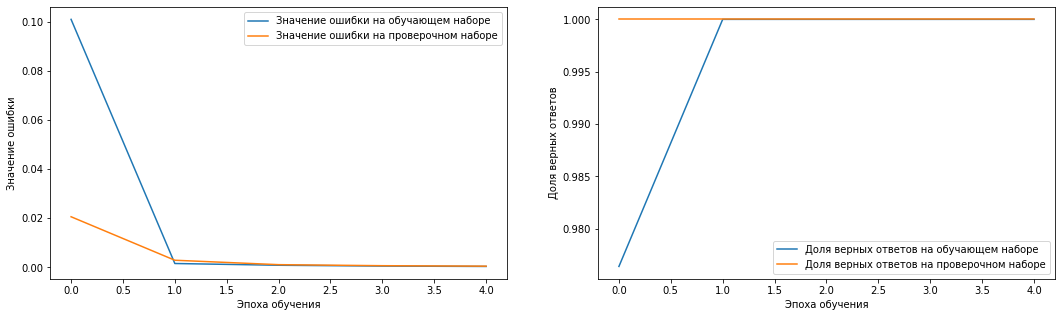

In [ ]:
#создаем полносвязную сеть
model = Sequential()
#первый полносвязный слой
model.add(Dense(200, input_dim=maxWordsCount, activation='relu'))
#слой регуляризации Dropout
model.add(Dropout(0.25))
#слой пакетной нормализации
model.add(BatchNormalization())
#выходной полносвязный слой
model.add(Dense(20, activation='softmax'))

#компилируем модель
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

#обучаем сеть
history = model.fit(xTrain01, yTrain, epochs=5, batch_size=256,
                    validation_data=(xTest01, yTest))

# выведем графики обучения
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss'
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2) 
# Отрисовка графиков 'accuracy' и 'val_accuracy'
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model, xTestBoW)

Класс: Беляев 100% сеть отнесла к классу Беляев Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков 100% сеть отнесла к классу Булгаков Это ПРАВИЛЬНЫЙ ответ!
Класс: Васильев 100% сеть отнесла к классу Васильев Это ПРАВИЛЬНЫЙ ответ!
Класс: Гоголь 100% сеть отнесла к классу Гоголь Это ПРАВИЛЬНЫЙ ответ!
Класс: Гончаров 100% сеть отнесла к классу Гончаров Это ПРАВИЛЬНЫЙ ответ!
Класс: Горький 100% сеть отнесла к классу Горький Это ПРАВИЛЬНЫЙ ответ!
Класс: Грибоедов 100% сеть отнесла к классу Грибоедов Это ПРАВИЛЬНЫЙ ответ!
Класс: Достоевский 100% сеть отнесла к классу Достоевский Это ПРАВИЛЬНЫЙ ответ!
Класс: Каверин 100% сеть отнесла к классу Каверин Это ПРАВИЛЬНЫЙ ответ!
Класс: Катаев 100% сеть отнесла к классу Катаев Это ПРАВИЛЬНЫЙ ответ!
Класс: Куприн 100% сеть отнесла к классу Куприн Это ПРАВИЛЬНЫЙ ответ!
Класс: Лермонтов 100% сеть отнесла к классу Лермонтов Это ПРАВИЛЬНЫЙ ответ!
Класс: Лесков 100% сеть отнесла к классу Лесков Это ПРАВИЛЬНЫЙ ответ!
Класс: Носов 100% сеть отнесла к классу Носов Это ПР

### Embedding

Epoch 1/10
136/136 [==============================] - 2s 10ms/step - loss: 1.6058 - accuracy: 0.5413 - val_loss: 2.7749 - val_accuracy: 0.0675
Epoch 2/10
136/136 [==============================] - 1s 9ms/step - loss: 0.0388 - accuracy: 0.9947 - val_loss: 1.4461 - val_accuracy: 0.5142
Epoch 3/10
136/136 [==============================] - 1s 9ms/step - loss: 0.0144 - accuracy: 0.9974 - val_loss: 0.2709 - val_accuracy: 0.9791
Epoch 4/10
136/136 [==============================] - 1s 9ms/step - loss: 0.0100 - accuracy: 0.9981 - val_loss: 0.0621 - val_accuracy: 0.9909
Epoch 5/10
136/136 [==============================] - 1s 9ms/step - loss: 0.0083 - accuracy: 0.9981 - val_loss: 0.0287 - val_accuracy: 0.9927
Epoch 6/10
136/136 [==============================] - 1s 9ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.2602 - val_accuracy: 0.9255
Epoch 7/10
136/136 [==============================] - 1s 9ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0565 - val_accuracy: 0.9813
Epoch

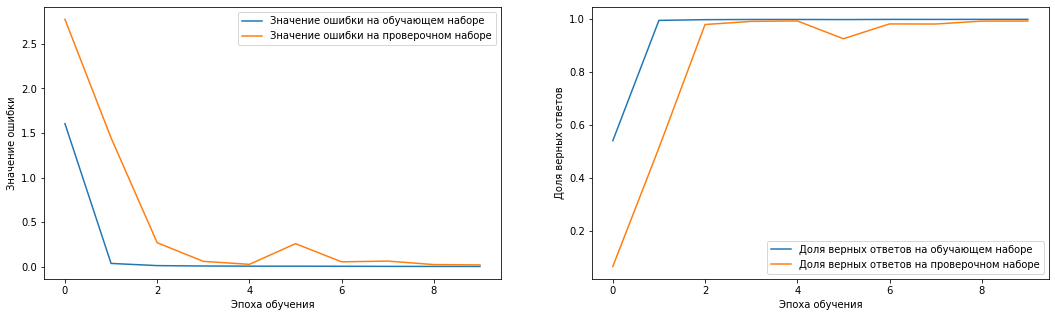

In [ ]:
#создаем полносвязную сеть
model = Sequential()
#добавляем слой Embedding
model.add(Embedding(maxWordsCount, 20, input_length=xLen))
#слой регуляризации
model.add(SpatialDropout1D(0.2))
#слой преобразования
model.add(Flatten())
#слой нормализации
model.add(BatchNormalization())
#полносвязный слой
model.add(Dense(200, activation="relu"))
#слой регуляризации
model.add(Dropout(0.2))
#слой нормализации
model.add(BatchNormalization())
#выходной полносвязный слой
model.add(Dense(20, activation='softmax'))

#компиляция модели
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
                metrics=['accuracy'])

#обучаем сеть
history = model.fit(xTrain, yTrain, epochs=10, batch_size=256, 
                    validation_data=(xTest, yTest))

# выведем графики обучения
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss'
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2) 
# Отрисовка графиков 'accuracy' и 'val_accuracy'
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

In [ ]:
#проверим точность
pred = recognizeMultiClass(model, xTestEmbedding)

Класс: Беляев 100% сеть отнесла к классу Беляев Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков 99% сеть отнесла к классу Булгаков Это ПРАВИЛЬНЫЙ ответ!
Класс: Васильев 100% сеть отнесла к классу Васильев Это ПРАВИЛЬНЫЙ ответ!
Класс: Гоголь 99% сеть отнесла к классу Гоголь Это ПРАВИЛЬНЫЙ ответ!
Класс: Гончаров 99% сеть отнесла к классу Гончаров Это ПРАВИЛЬНЫЙ ответ!
Класс: Горький 100% сеть отнесла к классу Горький Это ПРАВИЛЬНЫЙ ответ!
Класс: Грибоедов 97% сеть отнесла к классу Грибоедов Это ПРАВИЛЬНЫЙ ответ!
Класс: Достоевский 99% сеть отнесла к классу Достоевский Это ПРАВИЛЬНЫЙ ответ!
Класс: Каверин 100% сеть отнесла к классу Каверин Это ПРАВИЛЬНЫЙ ответ!
Класс: Катаев 100% сеть отнесла к классу Катаев Это ПРАВИЛЬНЫЙ ответ!
Класс: Куприн 89% сеть отнесла к классу Куприн Это ПРАВИЛЬНЫЙ ответ!
Класс: Лермонтов 99% сеть отнесла к классу Лермонтов Это ПРАВИЛЬНЫЙ ответ!
Класс: Лесков 100% сеть отнесла к классу Лесков Это ПРАВИЛЬНЫЙ ответ!
Класс: Носов 100% сеть отнесла к классу Носов Это ПРАВИЛЬНЫ

Выводы: Абсолютно максимальный результат и быстрее всех работает сеть на основе Bag of Words. Но у нее есть большой минус, занимает очень много оперативной памяти. Модель на основе Embeddinga также очень хорошо распознает авторов, обучается тоже быстро.